 # TellusLabs

CHI prediction with ARIMA model

In the previous analysis, we discovered that CHI shows similar moving patterns in each years with seasonality. In this blog we will predict CHI values with Python package 'statsmodels'. ARIMA stands for Autoregressive Integrated Moving Average and the model is available from statsmodels.

http://www.statsmodels.org/stable/index.html
https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average


Data Import
Historical U.S. corn CHI will be used for prediction

In [205]:
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-deep')
warnings.filterwarnings("ignore")

In [208]:
# import data, set index and convert it to datetime 
df_chi = pd.read_csv('./data/merged_chi_mutilated.csv', index_col='metric_date', parse_dates=True)
df_chi.head(3)

,crop,country_iso,geo_level,geo_id,geo_display_name,TELLUSCHIN
metric_date,,,,,,
2010-01-01,corn,USA,level_1,0,UNITED STATES,0.064150
2010-01-02,corn,USA,level_1,0,UNITED STATES,0.056903
2010-01-03,corn,USA,level_1,0,UNITED STATES,0.060015


In [209]:
# US data only
df_us = df_chi.loc[df_chi['geo_display_name']=='UNITED STATES']

To get rid of excessive fluctuation of the data we will use weekly average of CHI

In [210]:
# weekly average of data 
df_us_week = df_us.resample('W').mean()
df_us_week.head(3)

,geo_id,TELLUSCHIN
metric_date,,
2010-01-03,0,0.060356
2010-01-10,0,0.046097
2010-01-17,0,0.033196


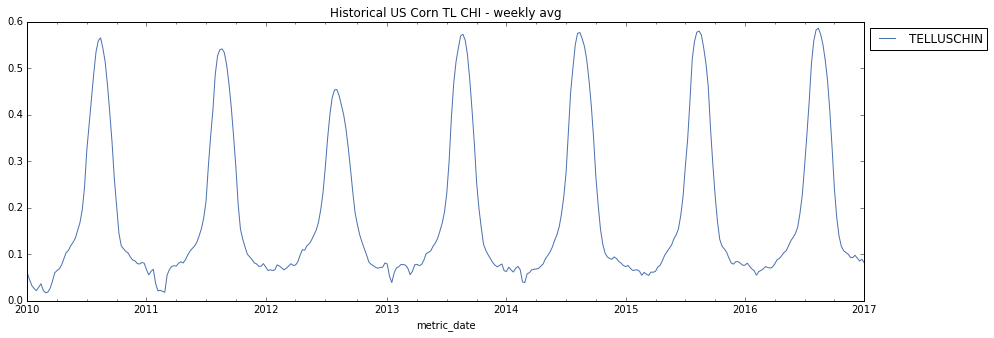

In [211]:
df_us_week['TELLUSCHIN'].plot(figsize=[15,5]);
plt.title('Historical US Corn TL CHI - weekly avg');
plt.legend(bbox_to_anchor=(1, 1), loc=2);

The data has clear seasonality but it is not clear if it has trend from the graph. To see make it stationary, we are going to do difference and run Dickey-Fuller test which is also available from statsmodels.

In [212]:
df_us_week['diff'] = df_us_week['TELLUSCHIN'] - df_us_week['TELLUSCHIN'].shift(1)
df_us_week['s_diff'] = df_us_week['diff'] - df_us_week['diff'].shift(52)
df_us_week['season_diff'] = df_us_week['TELLUSCHIN'] - df_us_week['TELLUSCHIN'].shift(52)
df_us_week.tail()

,geo_id,TELLUSCHIN,diff,s_diff,season_diff
metric_date,,,,,
2016-12-04,0,0.098057,0.004777,-0.000529,0.013695
2016-12-11,0,0.092054,-0.006003,-0.006087,0.007608
2016-12-18,0,0.085790,-0.006264,-0.002814,0.004794
2016-12-25,0,0.089556,0.003766,0.007978,0.012772
2017-01-01,0,0.082020,-0.007536,-0.007420,0.005352


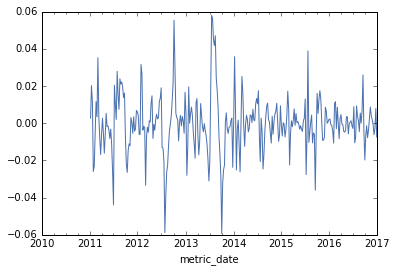

In [213]:
df_us_week['s_diff'].plot()

In [214]:
from statsmodels.tsa.stattools import adfuller

In [215]:
scheck1 = adfuller(df_us_week['s_diff'].dropna())
scheck1

(-8.0321342557391606,
 1.9455617879186684e-12,
 5L,
 307L,
 {'1%': -3.4518314994261337,
  '10%': -2.5718108789483178,
  '5%': -2.8710009653519166},
 -1789.477148432049)

In [216]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

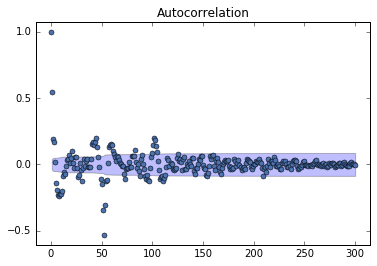

In [217]:
fig = plot_acf(df_us_week['s_diff'].dropna(),use_vlines=False,alpha=0.5, lags = 300)

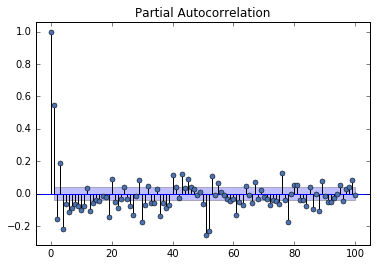

In [218]:
fig1 = plot_pacf(df_us_week['s_diff'].dropna(),use_vlines=True,alpha=0.5, lags = 100)

In [219]:
import statsmodels.api as sm

In [220]:
model = sm.tsa.statespace.SARIMAX(df_us_week['TELLUSCHIN'],order=(1,1,0), seasonal_order=(1,1,1,52))

In [221]:
results = model.fit()

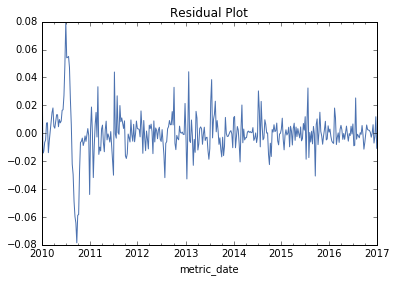

In [222]:
results.resid.plot();
plt.title('Residual Plot');

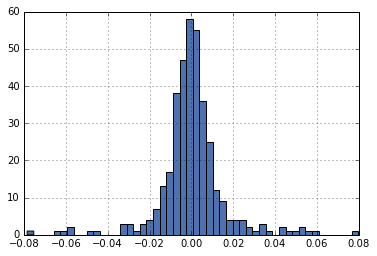

In [223]:
results.resid.hist(bins=50);

The residual plot and histogram above seem stable after 2010

('Max residual:', 0.079834276491149714)
('Min residual:', -0.078477926128874886)


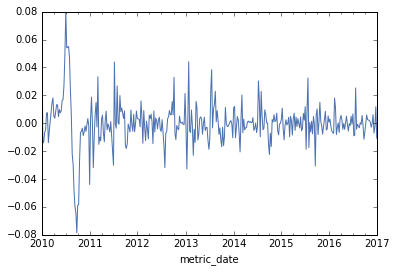

In [224]:
results.resid.loc['2009-01-01':].plot();
print ('Max residual:',results.resid.loc['2009-01-01':].max())
print ('Min residual:',results.resid.loc['2009-01-01':].min())

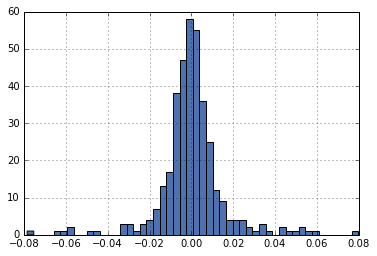

In [225]:
results.resid.loc['2009-01-01':].hist(bins=50);

Residual plot/histogram from 2009 - 2018

# TL CHI Prediciton with ARIMA

In [226]:
from pandas.tseries.offsets import DateOffset

In [227]:
date_ext = [df_us_week.index[-1]+DateOffset(weeks=x) for x in range(1,55)]

In [228]:
date_ext = pd.DataFrame(index=date_ext, columns=df_us_week.columns)

In [229]:
df_comb = pd.concat([df_us_week,date_ext])

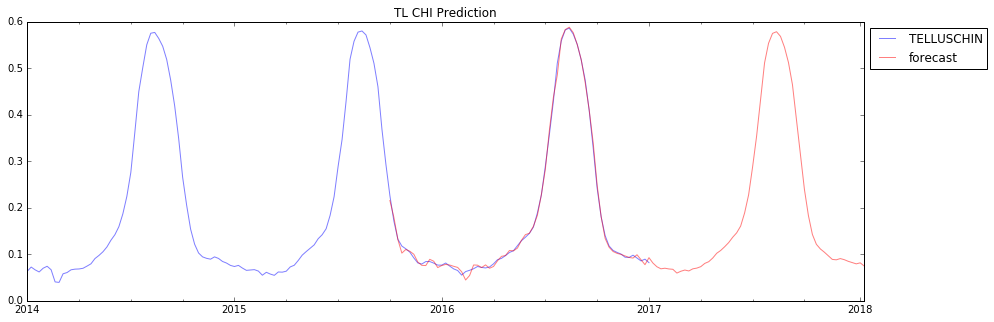

In [230]:
df_comb['forecast'] = results.predict(start=300, end=1000)
df_comb['TELLUSCHIN'].loc['2014-1-1':].plot(figsize=(15,5),alpha=0.5,color='b')
df_comb['forecast'].loc['2014-1-1':].plot(figsize=(15,5),alpha=0.5,color='r')

plt.title('TL CHI Prediction')
plt.legend(bbox_to_anchor=(1, 1), loc=2);

TL CHI vs Prediction graph

Blue - CHI

Red - prediction

2014 - 9/5/2015: TL CHI
9/6/2015 - 3/17/2018: TL CHI and prediction
3/18/2018 - 3/17/2019: prediction only